#### TOLIMAN Pupil Gluing Analysis: Preliminary Measurements

**Aim:**  
To determine:
1. The optical aberrations induced by the lab setup for pupil testing (consisting of 2 OAPs)
2. The intensity distribution ouput from the optical fiber output for later modelling

If we can show these aberrations are static over a long enough period of time (> 30min) then we can confidently remove them from the phase retrieval analysis of the later measurements (glued vs non-glued).

We have chosen to place a spider mask (necessary asymmetry) within the collimated beam to characterise these aberrations via phase retrieval (thank u differentiable modelling/dLux 💖)

In [1]:
import dLux as dl
import dLux.utils as dlu


import jax.numpy as jnp
import numpy as np
import jax.random as jr
import jax.scipy as jsp
from jax import vmap  

import zodiax as zdx
import optax
from tqdm.notebook import tqdm

from skimage.io import imread
from skimage.filters import window
import skimage as ski
from skimage.transform import resize

import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm

plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams['figure.figsize'] = (10,10)
plt.rcParams["axes.titlesize"] = 18
plt.rcParams["figure.titlesize"] = 18
plt.rcParams["axes.labelsize"] = 15

In [2]:
# ------- Physical Parameters ---------------------------------------------------------------------#
aperture_npix = 512           # Number of pixels across the aperture
aperture_diameter = 126e-3    # (m)
spider_width = 20e-3          # Spider width (m)
spider_angle =270             # Spider angle (degrees), clockwise, 0 is spider pointing vertically up
coords = dlu.pixel_coords(npixels=aperture_npix, diameter=aperture_diameter)
circle = dlu.circle(coords=coords, radius=aperture_diameter/2) 

# Observations wavelengths (bandpass of 530-640nm)
wavelengths = np.linspace(530e-9, 640e-9, 100)  # Wavelengths to simulate (m)
laser_wavelength =  635e-09  # for laser data
wf_npixels = aperture_npix  # Number of pixels across the wavefront
wf_diam = aperture_diameter             # Diameter of initial wavefront to propagate wavefront (m)

# Dtector parameters (BFS-U3-200S6-BD)
BFS_px_sep = 2.4e-6 *1e3        # pixel separation (mm)
f_det = 1300#1350                    # Focal length from OAP2 to detector (mm) 
px_ang_sep = 2*np.arctan( (BFS_px_sep/2)/f_det ) # angular sep between pixels (rad)

# Simulated Detector
psf_npix = 28                 # Number of pixels along one dim of the PSF
oversample = 1                 # Oversampling factor for the PSF
psf_pixel_scale = dlu.rad2arcsec(px_ang_sep) # arcsec (to match detector plate scale) 80e-4 


#### Load in some ✨real✨ data 🌈
- Check intensity distribution across pupil first


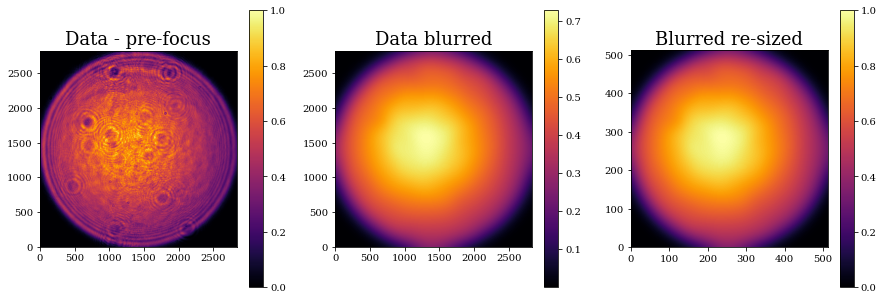

In [3]:
fname = "data/intensity/15_07_intensity_dist.png"
data = imread(fname, as_gray=True) 
manual_lim = [1363,4203,386,3214]
data = data[manual_lim[2]:manual_lim[3], manual_lim[0]:manual_lim[1]]
data = (data - data.min())/(data.max()-data.min())

blurred = ski.filters.gaussian(data, sigma=(120, 120))

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(data)
plt.title("Data - pre-focus")
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(blurred)
plt.title("Data blurred")
plt.colorbar()
plt.subplot(1,3,3)
intensity_dist = resize(blurred, (aperture_npix, aperture_npix))
intensity_dist = (intensity_dist - intensity_dist.min())/(intensity_dist.max()-intensity_dist.min()) # re-map from 0-1
# intensity_dist = np.fliplr(intensity_dist)
plt.title("Blurred re-sized")
plt.imshow(intensity_dist)
plt.colorbar()


Text(0.5, 1.0, 'Approximated WF intensity')

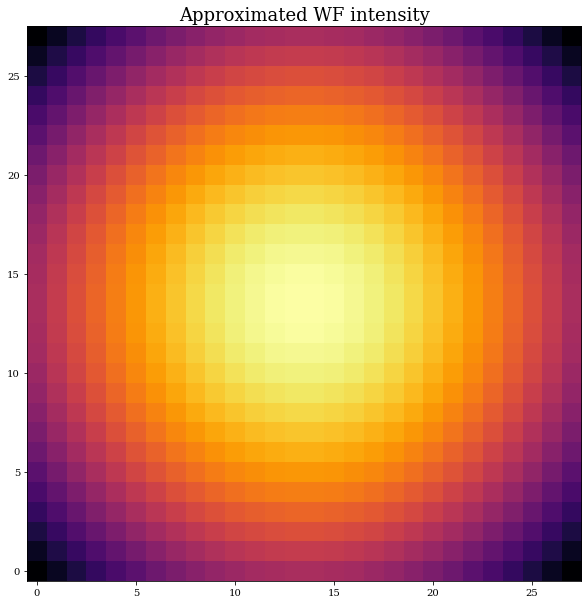

In [4]:
# Use 2D gaussian to approximate this
def gauss_2d(x_0, y_0, var_x, var_y, pixel_coords):
    """
        Output 2D gaussian array with amplitude of 1, within
        aperture profile.

        Parameters:
        -----------
        x_0, y_0 : float
            (x,y) coordinate of the center of the gaussian (m)
        var_x, var_y : float
            Variance in the x and y directions (m)
        pixel_coords : ndarray
            3D array of pixel coordinates over which gaussian is defined in the shape
            (2, npix, npix) where npix is the number of pixels across one dimension of the
            each 2D array (one for X and Y).
    """
    X, Y = pixel_coords

    z = jnp.exp(-(X - x_0)**2/(2*var_x**2) - (Y - y_0)**2/(2*var_y**2))

    return z

var = 10e-2
wf_pixel_coords = dlu.pixel_coords(npixels=psf_npix, diameter=wf_diam)
test = gauss_2d(x_0=0, y_0=0, var_x=var, var_y=var, pixel_coords=wf_pixel_coords)
plt.imshow(test)
plt.title("Approximated WF intensity")

In [5]:
# Create dLux class for this gauss transmissive layer
# maybe modelling a source object would be easier?
class GaussTransmissiveLayer(dl.layers.optical_layers.TransmissiveLayer):
    """
        Inherits from dl.layers.TransmissiveLayer and allows for
        a Gaussian transmissive layer to be simulated. Useful for 
        simulating a wavefront that is not uniform in intensity.

        Attributes
        ----------
        transmission: Array
            The Array of transmission values to be applied to the input wavefront.
        gaussian_param: Array = [var_x, var_y], shape (2,)
            The parameters defining the 2D Gaussian to be applied to the input wavefront.
            Where:
            var_x, var_y = float
                Variance in the x and y directions (m)
            Center of Gaussian is given by position of Pointsource
        pixel_coords : Array
            3D array of pixel coordinates over which gaussian is defined in the shape
            (2, npix, npix) where npix is the number of pixels across one dimension of the
            each 2D array (one for X and Y).
        det_npix: int
            Number of pixels across the detector.
        psf_pixel_scale: float
            Pixel scale of the detector (arcsec/px).
        normalise: bool
            Whether to normalise the wavefront after passing through the optic.
    """
    X: jnp.array
    Y: jnp.array

    gauss_param: jnp.array
    point_source: dl.PointSources
    det_npix: int
    pp_npix: int # pupil-plane pixel size
    psf_pixel_scale: float
    pixel_size: float

    def __init__(
        self: dl.layers.optical_layers.OpticalLayer,
        point_source: dl.PointSources,
        gaussian_param: jnp.array,
        pixel_coords: jnp.array,
        det_npix: int,
        psf_pixel_scale: float,
        normalise: bool = False,
    ):
        self.X, self.Y = pixel_coords
        assert gaussian_param.shape == (2,), "Gaussian parameters must be of shape (2,) in form [var_x, var_y] "
        self.pp_npix = self.X.shape[0]
        self.gauss_param = gaussian_param
        self.point_source = point_source

        self.det_npix = det_npix
        self.psf_pixel_scale = psf_pixel_scale
        self.pixel_size = jnp.abs(pixel_coords[0,0,1] - pixel_coords[0,0,0]) #distance between adjacent px

        trans = self.get_transmission()

        super().__init__(transmission=trans, normalise=normalise)

    def get_transmission(self):
        # angular position to number of pixels across detector
        pos = self.point_source.position[0]
        x_0_px = dlu.rad2arcsec(pos[0]) / self.psf_pixel_scale 
        y_0_px = dlu.rad2arcsec(pos[1]) / self.psf_pixel_scale 

        # convert to number of pixels across pupil plane
        x_0_px *= self.pp_npix / self.det_npix
        y_0_px *= self.pp_npix / self.det_npix 

        # convert to linear distance (m) across pupil plane
        x_0 = x_0_px*self.pixel_size
        y_0 = y_0_px*self.pixel_size

        # x_0 *= -1 #dLux conventions or Positon
        # y_0 *= -1

        z = jnp.exp(-(self.X - x_0)**2/(2*self.gauss_param[0]**2) - (self.Y - y_0)**2/(2*self.gauss_param[1]**2))

        return z 

    def apply(self: dl.layers.optical_layers.OpticalLayer, wavefront: dl.wavefronts.Wavefront) -> dl.wavefronts.Wavefront:
        """
        Applies the layer to the wavefront.

        Parameters
        ----------
        wavefront : Wavefront
            The wavefront to operate on.

        Returns
        -------
        wavefront : Wavefront
            The transformed wavefront.
        """
        wavefront *= self.get_transmission()
        if self.normalise:
            wavefront = wavefront.normalise()
        return wavefront


In [6]:
# # Create source class that inherits from dLux ResolvedSource class
# from jax.scipy.signal import convolve

# class GaussResolvedSource(dl.sources.ResolvedSource):
#     """
#         Inherits from dLux ResolvedSource class and allows for modelling
#         of a object with a Gaussian intensity profile. Useful for modelling
#         fiber optical source.

#         Attributes
#         ----------
#         position : Array, radians
#             The (x, y) on-sky position of this object.
#         flux : float, photons
#             The flux of the object.
#         distribution : Array
#             The array of intensities representing the resolved source.
#         spectrum : Spectrum
#             The spectrum of this object, represented by a Spectrum object.
#         gaussian_param: Array = [x_0, y_0, var_x, var_y], shape (4,)
#             The parameters defining the 2D Gaussian to be applied to the input wavefront.
#             Where:
#             x_0, y_0 = float
#                 (x,y) coordinate of the center of the gaussian (m)
#             var_x, var_y = float
#                 Variance in the x and y directions (m)
#         pixel_coords : Array
#             3D array of pixel coordinates describing the wavefront from the source.
#             Shape (2, npix, npix) where npix is the number of pixels across one 
#             dimension of the square wavefront (two 2D arrays, one for X coords and
#             the other for Y coords).
#     """
#     X: jnp.array
#     Y: jnp.array

#     gauss_param: jnp.array
#     def __init__(
#         self: dl.sources.Source,
#         gaussian_param: jnp.array,
#         pixel_coords: jnp.array,
#         wavelengths: jnp.array = None,
#         position: jnp.array = np.zeros(2),
#         flux: float = 1.0,
#         distribution: jnp.array = np.ones((3, 3)),
#         weights: jnp.array = None,
#         spectrum: dl.spectra.Spectrum = None,
#     ):

#         self.X, self.Y = pixel_coords
#         assert gaussian_param.shape == (4,), "Gaussian parameters must be of shape (4,) in form [x_0, y_0, var_x, var_y] "
#         self.gauss_param = gaussian_param

#         self.position = position
#         self.distribution = jnp.exp(-(self.X - self.position[0])**2/(2*self.gauss_param[2]**2) - (self.Y - self.position[1])**2/(2*self.gauss_param[3]**2))
        
#         super().__init__(
#             wavelengths=wavelengths,
#             position=position,
#             flux=flux,
#             distribution=self.distribution,
#             weights=weights,
#             spectrum=spectrum,
#         )
    
#     def get_distribution(self):
#         """
#             For every time gauss params are updated
#         """
#         # z = jnp.exp(-(self.X - self.gauss_param[0])**2/(2*self.gauss_param[2]**2) - (self.Y - self.gauss_param[1])**2/(2*self.gauss_param[3]**2))
#         z = jnp.exp(-(self.X - self.position[0])**2/(2*self.gauss_param[2]**2) - (self.Y - self.position[1])**2/(2*self.gauss_param[3]**2))

#         return z

#     def normalise(self: dl.sources.Source) -> dl.sources.Source:
#         """
#         Method for returning a new source object with a normalised total
#         spectrum and source distribution.

#         Returns
#         -------
#         source : Source
#             The source object with the normalised spectrum and distribution.
#         """
#         spectrum = self.spectrum.normalise()
#         distribution_floor = jnp.maximum(self.get_distribution(), 0.0)
#         distribution = distribution_floor / distribution_floor.sum()
#         return self.set(["spectrum", "distribution"], [spectrum, distribution])

#     def model(
#         self: dl.sources.Source,
#         optics: dl.optical_systems.BaseOpticalSystem = None,
#         return_wf : bool = False,
#         return_psf : bool = False
#     ) -> jnp.array:
#         """
#         Models the source object through the provided optics.

#         Parameters
#         ----------
#         optics : Optics
#             The optics through which to model the source object.
#         return_wf : bool = False
#             Should the Wavefront object be returned instead of the psf Array?
#         return_psf : bool = False
#             Should the PSF object be returned instead of the psf Array?

#         Returns
#         -------
#         object : Array
#             psf array
#         """
#         if return_wf and return_psf:
#             raise ValueError(
#                 "return_wf and return_psf cannot both be True. "
#                 "Please choose one."
#             )
        
#         # Normalise and get parameters
#         self = self.normalise()
#         weights = self.weights * self.flux


#         # Note we always return wf here so we can convolve each wavelength
#         # individually if a chromatic wavefront output is required.
#         wf = optics.propagate(
#             self.wavelengths, self.position, weights, return_wf=True
#         )

#         # Returning wf is a special case
#         if return_wf:
#             conv_fn = lambda psf: convolve(psf, self.get_distribution(), mode="same")
#             return wf.set("amplitude", vmap(conv_fn)(wf.psf) ** 0.5)

#         # Return psf object
#         conv_psf = convolve(wf.psf.sum(0), self.get_distribution(), mode="same")
#         if return_psf:
#             return dl.psfs.PSF(conv_psf, wf.pixel_scale.mean())

#         # Return array psf
#         return conv_psf


In [7]:
class GaussResolvedSource(dl.sources.PointSources):
    """
        Inherits from dLux PointSources class and allows for modelling
        of an object with a Gaussian intensity profile. Useful for modelling
        fiber optical source. Using PointSources instead of PointSource so that
        flux is casted as an array and can be optimised. 

        Attributes
        ----------
        position : Array, radians
            The (x, y) on-sky position of this object.
        flux : float, photons
            The flux of the object.
        spectrum : Spectrum
            The spectrum of this object, represented by a Spectrum object.
        gaussian_param: Array = [var_x, var_y], shape (2,)
            The parameters defining the 2D Gaussian to be applied to the input wavefront.
            Where:
            var_x, var_y = float
                Variance in the x and y directions (m)
            The x_0 and y_0 position of the gaussian is set to the position of the source.
        pixel_coords : Array
            3D array of pixel coordinates describing the wavefront from the source.
            Shape (2, npix, npix) where npix is the number of pixels across one 
            dimension of the square wavefront (two 2D arrays, one for X coords and
            the other for Y coords).
    """
    X: jnp.array
    Y: jnp.array

    gauss_param: jnp.array
    pixel_size: float

    def __init__(
        self: dl.sources.Source,
        gaussian_param: jnp.array,
        pixel_coords: jnp.array,
        wavelengths: jnp.array = None,
        position: jnp.array = np.zeros((1,2)),
        # flux: float = 1.0,
        flux: jnp.array = None,
        weights: jnp.array = None,
        spectrum: dl.spectra.Spectrum = None,
    ):

        self.X, self.Y = pixel_coords
        assert gaussian_param.shape == (2,), "Gaussian parameters must be of shape (2,) in form [var_x, var_y] "
        self.gauss_param = gaussian_param
        self.pixel_size = jnp.abs(pixel_coords[0,0,1] - pixel_coords[0,0,0]) #distance between adjacent px

        # More complex parameter checks here because of extra dims
        self.position = np.asarray(position, dtype=float)
        if self.position.ndim != 2:
            raise ValueError("position must be a 2d array.")

        if flux is None:
            self.flux = np.ones(len(self.position))
        else:
            self.flux = np.asarray(flux, dtype=float)

            if self.flux.ndim != 1:
                raise ValueError("flux must be a 1d array.")

            if len(self.flux) != len(self.position):
                raise ValueError(
                    "Length of flux must be equal to length of " "positions."
                )
        
        super().__init__(
            wavelengths=wavelengths,
            position=position,
            flux=flux,
            weights=weights,
            spectrum=spectrum,
        )
    
    def get_intensity_distribution(self, psf_pixel_scale: float = 1.0):
        """
            For every time gauss params are updated
            Gaussian with ampltidue of 1.
        """
        # angular position to linear units across detector
        pos = self.position[0]
        x_0 = dlu.rad2arcsec(pos[0]) / psf_pixel_scale * self.pixel_size
        y_0 = dlu.rad2arcsec(pos[1]) / psf_pixel_scale * self.pixel_size

        x_0 *= -1 #dLux conventions
        y_0 *= -1

        # z = jnp.exp(-(self.X - self.position[0])**2/(2*self.gauss_param[0]**2) - (self.Y - self.position[1])**2/(2*self.gauss_param[1]**2))
        z = jnp.exp(-(self.X - x_0)**2/(2*self.gauss_param[0]**2) - (self.Y - y_0)**2/(2*self.gauss_param[1]**2))


        return z
    
    def model(
        self: dl.sources.Source,
        optics: dl.optical_systems.BaseOpticalSystem = None,
        return_wf : bool = False,
        return_psf : bool = False
    ) -> jnp.array:
        """
        Models the source object through the provided optics.

        Parameters
        ----------
        optics : Optics
            The optics through which to model the source object.
        return_wf : bool = False
            Should the Wavefront object be returned instead of the psf Array?
        return_psf : bool = False
            Should the PSF object be returned instead of the psf Array?

        Returns
        -------
        object : Array, Wavefront, PSF
            if `return_wf` is False and `return_psf` is False, returns the psf Array.
            if `return_wf` is True and `return_psf` is False, returns the Wavefront
                object.
            if `return_wf` is False and `return_psf` is True, returns the PSF object.
        """
        
        # Normalise and get parameters
        self = self.normalise()
        weights = self.weights * self.flux
        
        # Note we always return wf here so we can ampltiude adjust each wavelength
        # we multiply by sqrt(weight) to account for the fact that the PSF is the 
        # square of the amplitude
        wf = optics.propagate(
            self.wavelengths, self.position[0], weights, return_wf=True
        )

        wf = wf.multiply("amplitude", self.get_intensity_distribution(optics.psf_pixel_scale)** 0.5)

        # Returning wf is a special case
        if return_wf:
            return wf

        # Return psf object
        if return_psf:
            return dl.psfs.PSF(wf.psf.sum(0), wf.pixel_scale.mean())

        # Return array psf
        return wf.psf.sum(0)



In [8]:
# Define non-linear detector response
class ApplyBFSPixelResponse(dl.layers.detector_layers.DetectorLayer):
    """
    Applies a pixel response array to the input psf, via a multiplication. This can be
    used to model variations in the inter and intra-pixel sensitivity variations common
    to most detectors.

    ??? abstract "UML"
        ![UML](../../assets/uml/ApplyPixelResponse.png)

    Attributes
    ----------
    pixel_response : Array
        The pixel_response to apply to the input psf.
    """

    pixel_response: jnp.array

    def __init__(self: dl.layers.detector_layers.DetectorLayer, 
                 pixel_response: jnp.array = jnp.array([1.0, 0.0])
                 ):
        """
        Parameters
        ----------
        pixel_response : Array
            The pixel_response to apply to the input psf. Must be a 2-dimensional array
            equal to size of the psf at time of application.
        """
        super().__init__()
        self.pixel_response = np.asarray(pixel_response, dtype=float)

    def apply(self: dl.layers.detector_layers.DetectorLayer, psf: dl.PSF) -> dl.PSF:
        """
        Applies the layer to the PSF.

        Parameters
        ----------
        psf : PSF
            The psf to operate on.

        Returns
        -------
        psf : PSF
            The transformed psf.
        """
        psf_array = psf.data
        # cubic approximation for now - good when non-linearity is very small
        # psf_array += self.pixel_response[0]*psf_array**2 + self.pixel_response[1]*psf_array**3 
        psf_array = psf_array**self.pixel_response[0] * self.pixel_response[1]
        psf_obj = dl.PSF(data = psf_array, pixel_scale = psf.pixel_scale)
        return psf_obj


Total flux: 103.50421905517578


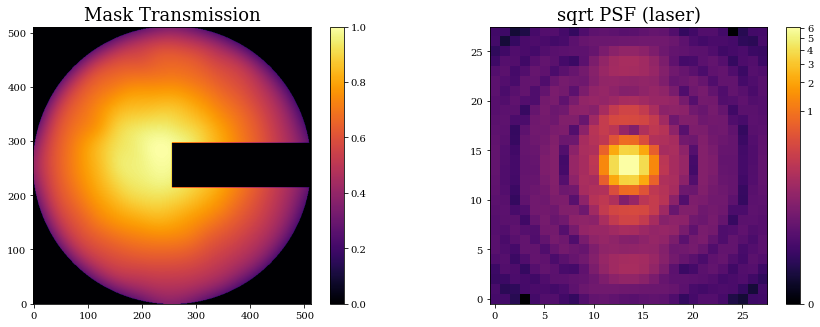

In [56]:
# --- Simulate Spider -----------------------------------------------------------------#
spider = dlu.spider(coords=coords, width=spider_width, angles=[spider_angle])
transmission = dlu.combine([circle, spider])*intensity_dist

# Zernike aberrations
zernike_indicies = jnp.arange(4, 15) # up to 10th noll idxs (excluding piston)
coeffs = jnp.zeros(zernike_indicies.shape)
basis = dlu.zernike_basis(js=zernike_indicies, coordinates=coords, diameter=aperture_diameter)

# Using PointSources instead of single PointSource object to overcome float grad issue 
# https://github.com/LouisDesdoigts/dLux/issues/271 
src = dl.PointSources(wavelengths=[laser_wavelength], flux =jnp.asarray([1e8],dtype=float))
wf_pixel_coords = dlu.pixel_coords(npixels=psf_npix, diameter=wf_diam)
# src = GaussResolvedSource(gaussian_param=np.array([10e-2,10e-2]), 
#                           pixel_coords=wf_pixel_coords, 
#                           wavelengths=jnp.array([laser_wavelength]), 
#                           flux=jnp.array([1e8]) # trying to overcome zdx issues
#                           )

layers = [
    # ('intensity_prof', GaussTransmissiveLayer(point_source=src,
    #                                           gaussian_param=jnp.array([5e-2,5e-2]),
    #                                           pixel_coords=coords,
    #                                           det_npix=psf_npix,
    #                                           psf_pixel_scale=psf_pixel_scale)),
    ('aperture', dl.layers.BasisOptic(basis, transmission, coeffs, normalise=False)),
]

# Construct Optics
optics = dl.AngularOpticalSystem(wf_npixels = wf_npixels, 
                                diameter=wf_diam, 
                                layers=layers, 
                                psf_npixels=psf_npix, 
                                psf_pixel_scale=psf_pixel_scale,
                                oversample=oversample)

# Create detector layer to characterise non-linear response of BFS det 
# simple multiplicative - might need regularisation for this, idk 
# pixel_response = 1 + 0.05*jr.normal(jr.PRNGKey(0), [psf_npix, psf_npix])
pixel_response = jnp.array([1/1.2, 1.0])
detector = dl.LayeredDetector([ApplyBFSPixelResponse(pixel_response=pixel_response)])


instrument = dl.Telescope(optics, ('source', src), detector)
sim_psf = instrument.model()

# Show setup and transmission results
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
# plt.imshow(transmission*instrument.optics.intensity_prof.transmission)
plt.imshow(transmission)
plt.colorbar()
plt.title('Mask Transmission')
plt.subplot(1,2,2)
norm_psf = PowerNorm(0.2, vmax=sim_psf.max(), vmin=sim_psf.min())
print("Total flux: {}".format(sim_psf.sum()))
plt.imshow(sim_psf, norm=norm_psf)
plt.title('sqrt PSF (laser)')
plt.colorbar()


#### Load in spider images ⭐️
- 09_laser_90deg_200us_0gain_img_stack_batch_0.npy: Spider (90 deg oriented) setup with laser
- 10_laser_90deg_200us_0gain_img_stack_batch_0.npy: Same setup as above scenario, data taken ~1hr later 

Total flux (Raw): 1107122.125
Total flux (Scaled): 131.3780059814453


Text(0.5, 1.0, 'Simulated')

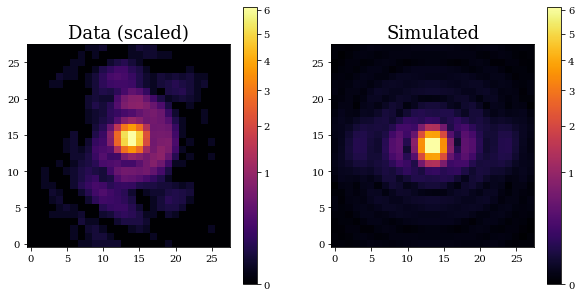

In [73]:
# fname = "data/spider/05_laser_90deg_mean.npy"
# data = imread(fname, as_gray=True) NOTE: DO NOT USE IMREAD - CONVERSION TO FLOAT LOSES INFO
# data = np.load(fname) 

fname = "data/spider/09_laser_90deg_200us_0gain_img_stack_batch_0.npy" #data/spider/08_laser_90deg_img_stack.npy"
data = np.load(fname)
data = data[-1,:,:]

bckgnd = np.load("data/spider/10_laser_90deg_bckgnd_200us_0gain_img_stack_batch_0.npy")
bckgnd = np.mean(bckgnd)
data = data - bckgnd

# Scale intensity
# data += data.max()*0.1 # effectively create a black level NOTE fit gets worse with this
# data = data**1.2 # non-linear behaviour estimation
current_range = data.max() - data.min()
new_range = sim_psf.max() - sim_psf.min()
scaled_data = ( (data - data.min()) * new_range )/current_range + sim_psf.min()
# new_range = data.max() - 0
# scaled_data = ( (data - data.min()) * new_range )/current_range + 0

psf_center_idx = np.unravel_index(np.argmax(scaled_data, axis=None), scaled_data.shape)
psf_hlf_sz = 14
scaled_data = scaled_data[psf_center_idx[0]-psf_hlf_sz:psf_center_idx[0]+psf_hlf_sz,
                            psf_center_idx[1]-psf_hlf_sz:psf_center_idx[1]+psf_hlf_sz]

data = data[psf_center_idx[0]-psf_hlf_sz:psf_center_idx[0]+psf_hlf_sz,
                            psf_center_idx[1]-psf_hlf_sz:psf_center_idx[1]+psf_hlf_sz]
data = data + sim_psf.min() # ensure mu = 0 for k !=0 does not occur (logpmf shits itself)

print("Total flux (Raw): {}".format(data.sum()))
print("Total flux (Scaled): {}".format(scaled_data.sum()))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(scaled_data, norm=norm_psf)
# plt.imshow(data**0.2)
plt.colorbar()
plt.title("Data (scaled)")
plt.subplot(1,2,2)
plt.imshow(sim_psf, norm=norm_psf)
plt.colorbar()
plt.title("Simulated")

# plt.figure()
# plt.imshow()

#### Phase Retrieval

In [ ]:
# @zdx.filter_jit
# @zdx.filter_value_and_grad(param)
# def loss_fn_mse(model, data, wavelength_center):

#     simu_psf = model.propagate_mono(wavelength_center)

#     mse = 1/simu_psf.size * ((data-simu_psf)**2).sum()

#     return mse

In [58]:
params = [
    'aperture.coefficients',
    'source.position',
    # 'optics.intensity_prof.gauss_param',
    'source.flux', 
    # 'detector.ApplyBFSPixelResponse.pixel_response',
    ]
@zdx.filter_jit
@zdx.filter_value_and_grad(params)
def loss_fn_gaussian(model, data):

    simu_psf = model.model()

    uncertainty = 0.1 # 10% err per pix TODO try increasing

    loss = -jsp.stats.norm.logpdf(x=simu_psf, loc=data, scale=data*uncertainty).sum()

    return loss
@zdx.filter_jit
@zdx.filter_value_and_grad(params)
def loss_fn_poisson(model, data):

    simu_psf = model.model()

    loss = -jsp.stats.poisson.logpmf(k=simu_psf, mu=data).sum()

    return loss

In [59]:
learning_rate = 1e-9
# optimisers = [
#             optax.adam(optax.linear_schedule(init_value=learning_rate, end_value=0, transition_begin=5000, transition_steps=1)),
#             optax.adam(optax.linear_schedule(init_value=learning_rate, end_value=0, transition_begin=5000, transition_steps=1)),
#             # optax.adam(optax.piecewise_constant_schedule(init_value=1e-2*1e4, boundaries_and_scales={400: int(1e4)})),
#             optax.adam(optax.linear_schedule(init_value=0, end_value=1e-3, transition_begin=5000, transition_steps=1)),
#             optax.adam(learning_rate=1e6),
#             # optax.adam(optax.linear_schedule(init_value=1e4, end_value=0, transition_begin=5000, transition_steps=1)),
#             # optax.adam(optax.linear_schedule(init_value=0, end_value=1e6, transition_begin=500, transition_steps=1)),
#             # optax.adam(learning_rate=1e6),
#             # optax.adam(learning_rate=1e-3),
#               ]
optimisers = [
            optax.adam(learning_rate=learning_rate),
            optax.adam(learning_rate=learning_rate),
            # optax.adam(learning_rate=1e-4),
            optax.adam(learning_rate=1e6),
            # optax.adam(learning_rate=1e-2),
              ]


# Optimise flux first
optim, opt_state = zdx.get_optimiser(instrument, params, optimisers) # Needs to be iterable param (i.e. accessible via instrument class)

progress_bar = tqdm(range(5000), desc='Loss: ')

# Run optimisation loop 
net_losses, Coeffs, Positions, Fluxes, Dist_sum, Pix_resp = [],[],[],[], [], []
for i in progress_bar:
    poiss_loss, poiss_grads = loss_fn_poisson(model = instrument, data = scaled_data)

    updates, opt_state = optim.update(poiss_grads, opt_state)
    instrument = zdx.apply_updates(instrument, updates) 

    net_losses.append(poiss_loss)
    Fluxes.append(instrument.source.flux)
    Coeffs.append(instrument.aperture.coefficients)
    Positions.append(instrument.source.position)
    # Dist_sum.append(instrument.optics.intensity_prof.gauss_param)
    Pix_resp.append(instrument.detector.ApplyBFSPixelResponse.pixel_response)
    
    progress_bar.set_postfix({'Loss': poiss_loss})




Loss:   0%|          | 0/5000 [00:00<?, ?it/s]

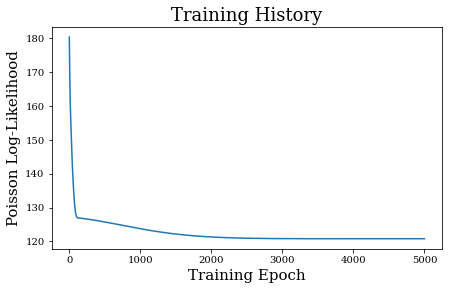

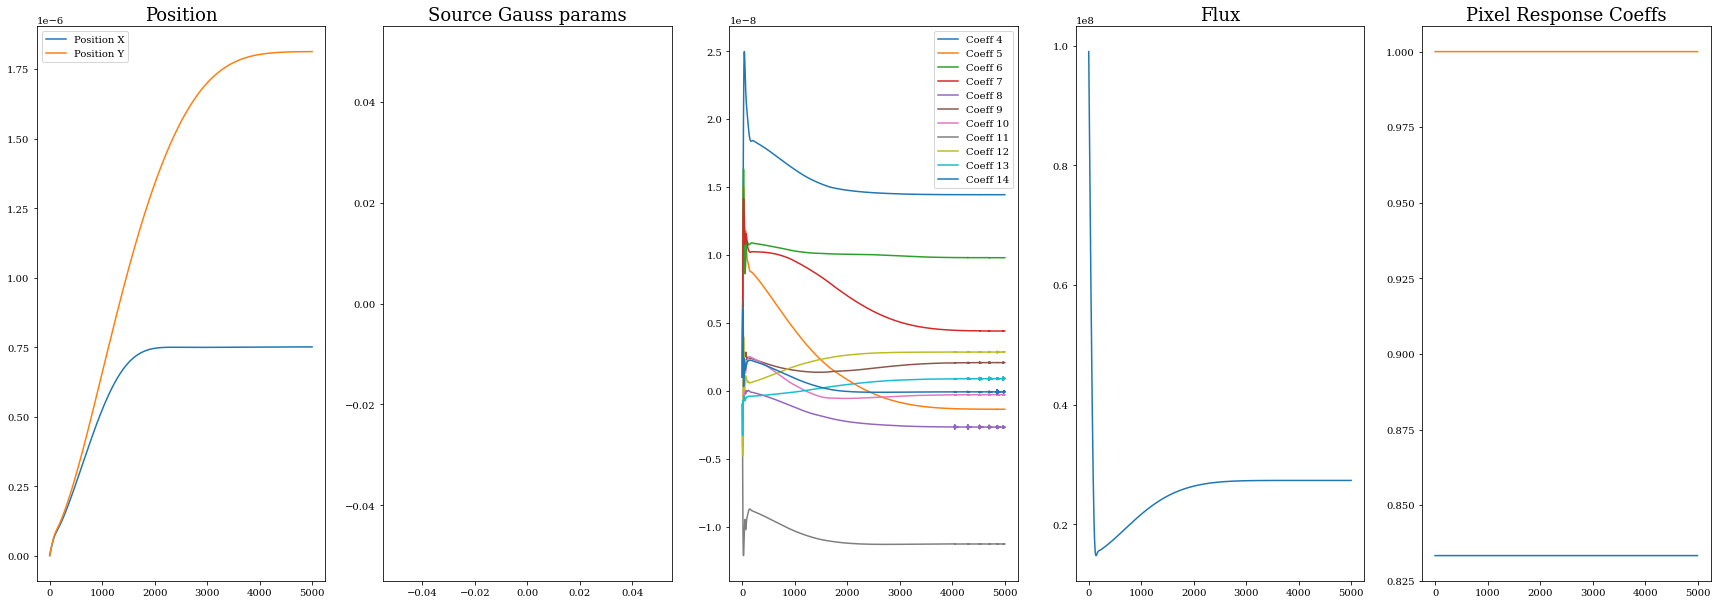

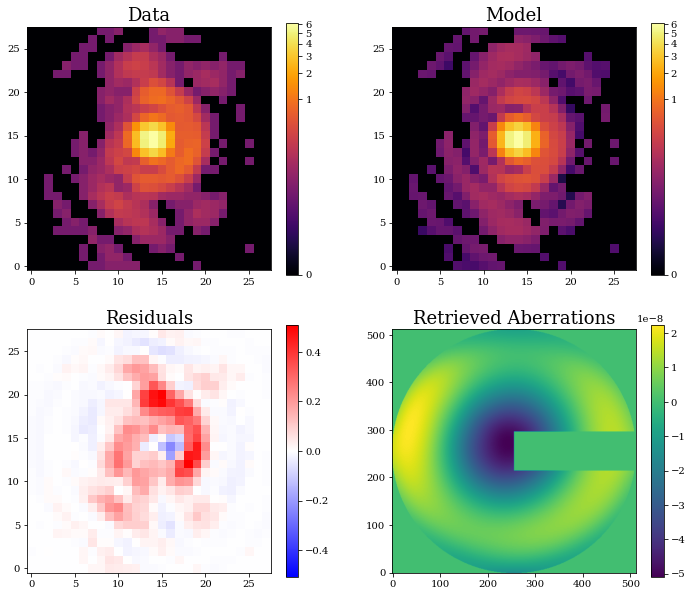

In [60]:
# Visualise results
%matplotlib inline
plt.figure(figsize=(7,4))
plt.plot(np.array(net_losses))
ax = plt.gca()
ax.set_title("Training History")
ax.set_xlabel("Training Epoch")
ax.set_ylabel("Poisson Log-Likelihood")

plt.rcParams['figure.figsize'] = (17, 17)
plt.rcParams['image.cmap'] = 'inferno'

plt.figure(figsize=(30,10))
plt.subplot(1,5,1)
plt.plot(np.asarray(Positions)[:,0,0], label="Position X")
plt.plot(np.asarray(Positions)[:,0,1], label="Position Y")
# plt.plot(np.asarray(Positions)[:,0], label="Position X")
# plt.plot(np.asarray(Positions)[:,1], label="Position Y")
plt.title("Position")
plt.legend()
plt.subplot(1,5,2)
plt.plot(np.asarray(Dist_sum))
plt.title("Source Gauss params")
plt.subplot(1,5,3)
arr_coeffs = np.asarray(Coeffs)
for i in range(len(Coeffs[0])):
    label = "Coeff " + str(zernike_indicies[i])
    plt.plot(arr_coeffs[:,i], label=label)
plt.legend()
plt.subplot(1,5,4)
plt.plot(np.asarray(Fluxes))
plt.title("Flux")
plt.subplot(1,5,5)
plt.plot(np.asarray(Pix_resp))
plt.title("Pixel Response Coeffs")

plt.figure(figsize=(12,10))
norm_psf = PowerNorm(0.2, vmax=scaled_data.max(), vmin=scaled_data.min())
plt.subplot(2,2,1)
plt.imshow(scaled_data, norm=norm_psf)
plt.colorbar()
plt.title('Data')

plt.subplot(2,2,2)
model_psf = instrument.model()
current_range = model_psf.max() - model_psf.min()
new_range = scaled_data.max() - scaled_data.min()
model_psf = ( (model_psf - model_psf.min()) * new_range )/current_range + scaled_data.min()
norm_psf = PowerNorm(0.2, vmax=model_psf.max(), vmin=model_psf.min())
mask = np.ones(scaled_data.shape)
mask[scaled_data < 0.01] = 0
plt.imshow(model_psf*mask, norm=norm_psf)
plt.title('Model')
plt.colorbar()

plt.subplot(2,2,3)
resid = scaled_data - model_psf
# resid = data - model_psf
plt.imshow(resid, cmap='bwr', vmax = np.abs(resid).max(), vmin = -np.abs(resid).max())
plt.colorbar()
plt.title('Residuals')

plt.subplot(2,2,4)
opd = instrument.aperture.eval_basis()
plt.imshow(opd*transmission, cmap='viridis')
plt.title('Retrieved Aberrations')
plt.colorbar()

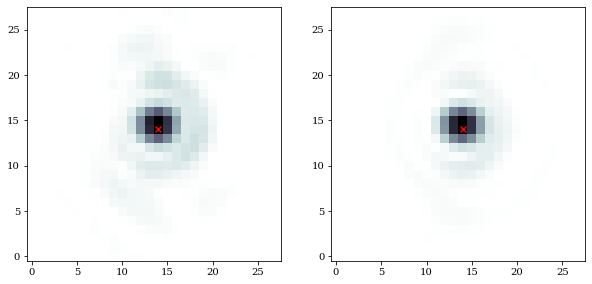

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(scaled_data, cmap='bone_r')
ax[1].imshow(model_psf, cmap='bone_r') 

point = [14, 14]

for i in [0, 1]:
    ax[i].scatter(*point, marker='x', color='r')

plt.show()

In [62]:
print("Found coefficients for noll idxs: {}\n{}".format(zernike_indicies, instrument.optics.aperture.coefficients))

run1_coeffs = instrument.optics.aperture.coefficients
s = run1_coeffs

Found coefficients for noll idxs: [ 4  5  6  7  8  9 10 11 12 13 14]
[ 1.4438430e-08 -1.3602250e-09  9.7984891e-09  4.4000821e-09
 -2.6862126e-09  2.0751385e-09 -2.9715072e-10 -1.1278611e-08
  2.8591916e-09  8.9687374e-10 -5.9296304e-11]


Lets try with second data set... (1hr apart)

In [63]:
# Re-initialise model
optics = dl.AngularOpticalSystem(wf_npixels = wf_npixels, 
                                diameter=wf_diam, 
                                layers=layers, 
                                psf_npixels=psf_npix, 
                                psf_pixel_scale=psf_pixel_scale,
                                oversample=oversample)

instrument = dl.Telescope(optics, ('source', src), detector)
print(instrument.optics.aperture.coefficients, instrument.source.position)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [[0. 0.]]


Text(0.5, 1.0, 'Simulated')

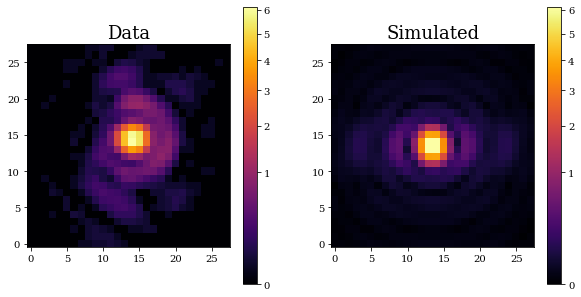

In [72]:
fname = "data/spider/10_laser_90deg_200us_0gain_img_stack_batch_0.npy" #data/spider/08_laser_90deg_img_stack.npy"
data = np.load(fname)
data = data[-1,:,:]

bckgnd = np.load("data/spider/10_laser_90deg_bckgnd_200us_0gain_img_stack_batch_0.npy") 
bckgnd = np.mean(bckgnd)
data = data - bckgnd

# Scale intensity
current_range = data.max() - data.min()
new_range = sim_psf.max() - sim_psf.min()
scaled_data = ( (data - data.min()) * new_range )/current_range + sim_psf.min()

psf_center_idx = np.unravel_index(np.argmax(scaled_data, axis=None), scaled_data.shape)
psf_hlf_sz = 14
scaled_data = scaled_data[psf_center_idx[0]-psf_hlf_sz:psf_center_idx[0]+psf_hlf_sz,
                            psf_center_idx[1]-psf_hlf_sz:psf_center_idx[1]+psf_hlf_sz]

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(scaled_data, norm = norm_psf)
plt.colorbar()
plt.title("Data")
plt.subplot(1,2,2)
plt.imshow(sim_psf, norm = norm_psf)
plt.colorbar()
plt.title("Simulated")

In [65]:
learning_rate = 1e-9
optimisers = [
            optax.adam(learning_rate=learning_rate),
            optax.adam(learning_rate=learning_rate),
            # optax.adam(learning_rate=1e-4),
            optax.adam(learning_rate=1e6),
            # optax.adam(learning_rate=1e-2),
              ]


# Optimise flux first
optim, opt_state = zdx.get_optimiser(instrument, params, optimisers) # Needs to be iterable param (i.e. accessible via instrument class)

progress_bar = tqdm(range(5000), desc='Loss: ')

# Run optimisation loop 
net_losses, Coeffs, Positions, Fluxes, Dist_sum, Pix_resp = [],[],[],[], [], []
for i in progress_bar:
    poiss_loss, poiss_grads = loss_fn_poisson(model = instrument, data = scaled_data)

    updates, opt_state = optim.update(poiss_grads, opt_state)
    instrument = zdx.apply_updates(instrument, updates) 

    net_losses.append(poiss_loss)
    Fluxes.append(instrument.source.flux)
    Coeffs.append(instrument.aperture.coefficients)
    Positions.append(instrument.source.position)
    # Dist_sum.append(instrument.optics.intensity_prof.gauss_param)
    Pix_resp.append(instrument.detector.ApplyBFSPixelResponse.pixel_response)
    
    progress_bar.set_postfix({'Loss': poiss_loss})


Loss:   0%|          | 0/5000 [00:00<?, ?it/s]

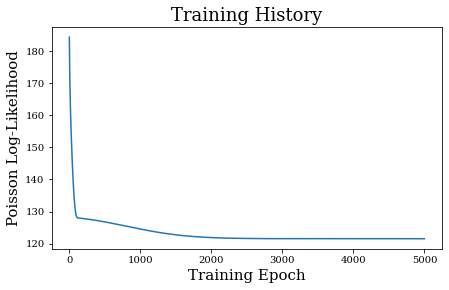

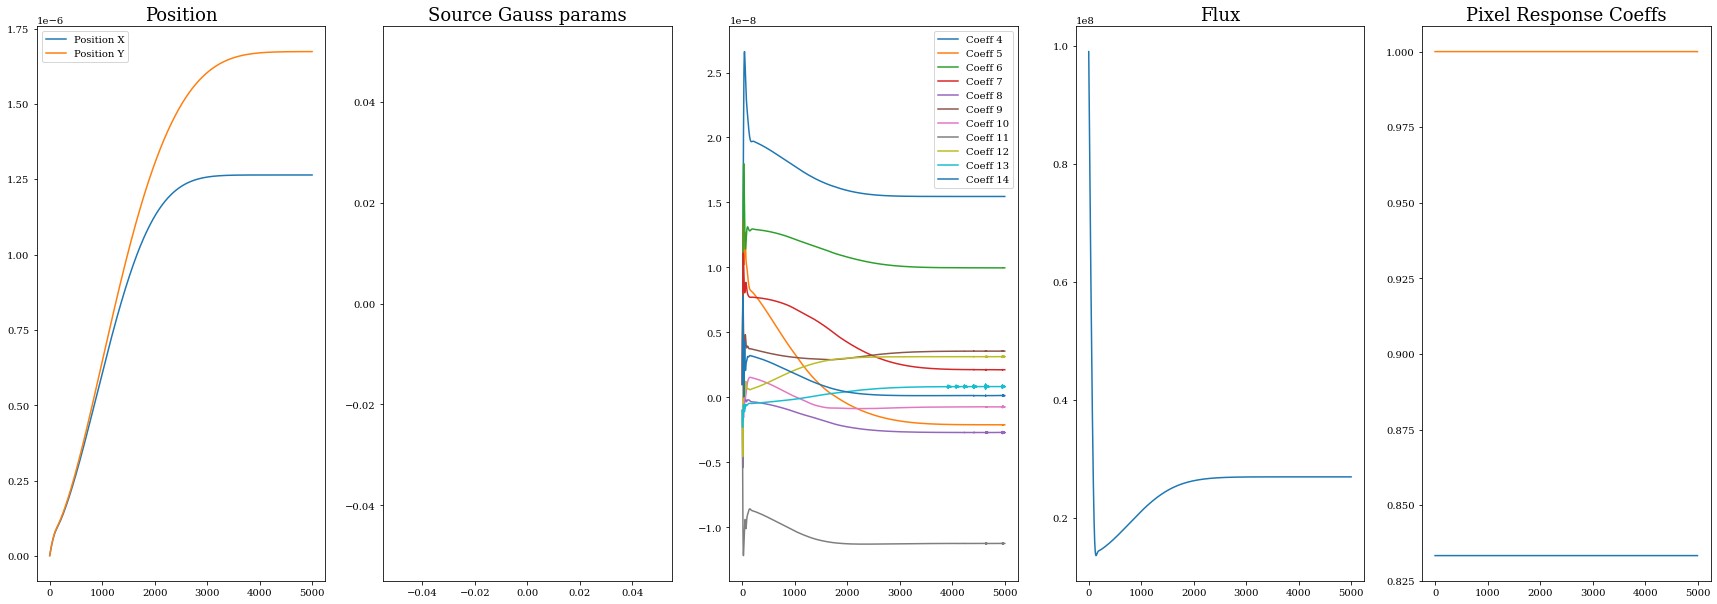

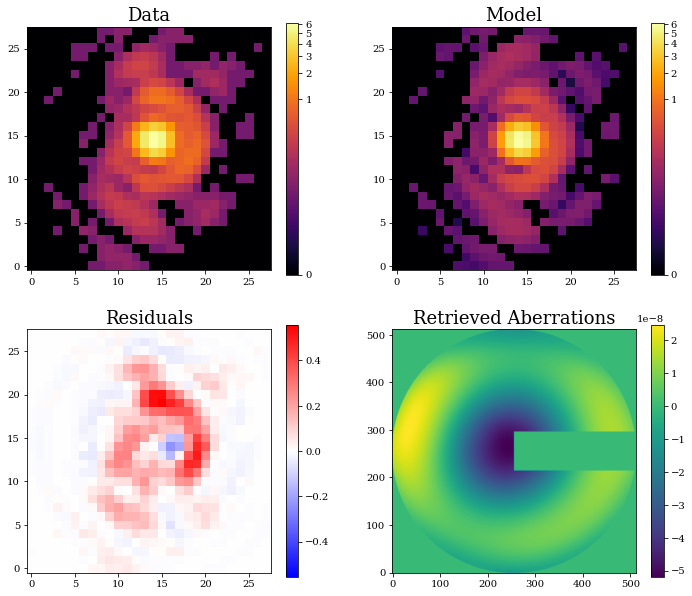

In [66]:
# Visualise results
%matplotlib inline
plt.figure(figsize=(7,4))
plt.plot(np.array(net_losses))
ax = plt.gca()
ax.set_title("Training History")
ax.set_xlabel("Training Epoch")
ax.set_ylabel("Poisson Log-Likelihood")

plt.rcParams['figure.figsize'] = (17, 17)
plt.rcParams['image.cmap'] = 'inferno'

plt.figure(figsize=(30,10))
plt.subplot(1,5,1)
plt.plot(np.asarray(Positions)[:,0,0], label="Position X")
plt.plot(np.asarray(Positions)[:,0,1], label="Position Y")
# plt.plot(np.asarray(Positions)[:,0], label="Position X")
# plt.plot(np.asarray(Positions)[:,1], label="Position Y")
plt.title("Position")
plt.legend()
plt.subplot(1,5,2)
plt.plot(np.asarray(Dist_sum))
plt.title("Source Gauss params")
plt.subplot(1,5,3)
arr_coeffs = np.asarray(Coeffs)
for i in range(len(Coeffs[0])):
    label = "Coeff " + str(zernike_indicies[i])
    plt.plot(arr_coeffs[:,i], label=label)
plt.legend()
plt.subplot(1,5,4)
plt.plot(np.asarray(Fluxes))
plt.title("Flux")
plt.subplot(1,5,5)
plt.plot(np.asarray(Pix_resp))
plt.title("Pixel Response Coeffs")

plt.figure(figsize=(12,10))
norm_psf = PowerNorm(0.2, vmax=scaled_data.max(), vmin=scaled_data.min())
plt.subplot(2,2,1)
plt.imshow(scaled_data, norm=norm_psf)
plt.colorbar()
plt.title('Data')

plt.subplot(2,2,2)
model_psf = instrument.model()
current_range = model_psf.max() - model_psf.min()
new_range = scaled_data.max() - scaled_data.min()
model_psf = ( (model_psf - model_psf.min()) * new_range )/current_range + scaled_data.min()
norm_psf = PowerNorm(0.2, vmax=model_psf.max(), vmin=model_psf.min())
mask = np.ones(scaled_data.shape)
mask[scaled_data < 0.01] = 0
plt.imshow(model_psf*mask, norm=norm_psf)
plt.title('Model')
plt.colorbar()

plt.subplot(2,2,3)
resid = scaled_data - model_psf
# resid = data - model_psf
plt.imshow(resid, cmap='bwr', vmax = np.abs(resid).max(), vmin = -np.abs(resid).max())
plt.colorbar()
plt.title('Residuals')

plt.subplot(2,2,4)
opd = instrument.aperture.eval_basis()
plt.imshow(opd*transmission, cmap='viridis')
plt.title('Retrieved Aberrations')
plt.colorbar()

Found coefficients for noll idxs: [ 4  5  6  7  8  9 10 11 12 13 14]
[ 1.5460465e-08 -2.1093458e-09  9.9684812e-09  2.1297313e-09
 -2.7063227e-09  3.5596726e-09 -7.3248491e-10 -1.1241151e-08
  3.1346035e-09  8.1874874e-10  1.3635955e-10]


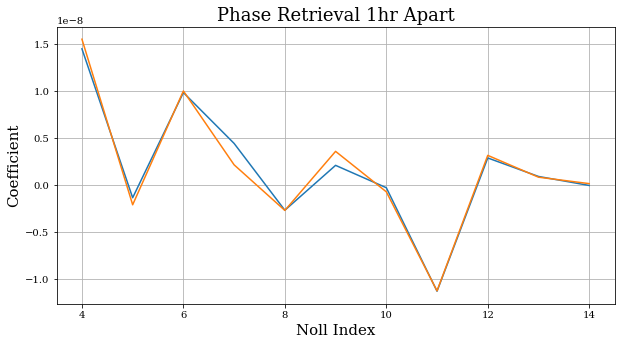

In [67]:
print("Found coefficients for noll idxs: {}\n{}".format(zernike_indicies, instrument.optics.aperture.coefficients))

run2_coeffs = instrument.optics.aperture.coefficients

plt.figure(figsize=(10,5))
x = np.arange(2,11)
plt.plot(zernike_indicies,run1_coeffs, label='Run 1')
plt.plot(zernike_indicies, run2_coeffs, label='Run 2')
plt.xlabel('Noll Index')
plt.ylabel('Coefficient')
plt.title("Phase Retrieval 1hr Apart")
plt.grid()

#### Lets look at different orientation of spider 🕷️🕸️
- 11_laser_180deg_80us_3gain_img_stack_batch_0.npy
- 12_laser_180deg_80us_3gain_img_stack_batch_0.npy

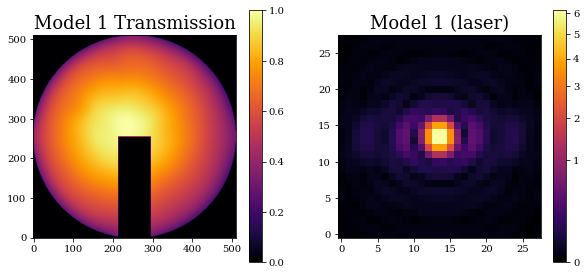

In [77]:
circle = dlu.circle(coords=coords, radius=aperture_diameter/2) 
spider = dlu.spider(coords=coords, width=spider_width, angles=[0]) 
transmission = dlu.combine([circle, spider]) 
transmission *= intensity_dist

# Zernike aberrations
coeffs = np.zeros(zernike_indicies.shape)
basis = dlu.zernike_basis(js=zernike_indicies, coordinates=coords, diameter=aperture_diameter)

layers = [
    ('aperture', dl.layers.BasisOptic(basis, transmission, coeffs, normalise=False))
]

# Construct Optics
optics = dl.AngularOpticalSystem(wf_npixels = wf_npixels, 
                                diameter=wf_diam, 
                                layers=layers, 
                                psf_npixels=psf_npix, 
                                psf_pixel_scale=psf_pixel_scale,
                                oversample=oversample)
instrument = dl.Telescope(optics, ('source', src), detector)


sim_psf = instrument.model()
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(transmission)
plt.colorbar()
plt.title('Model 1 Transmission')
plt.subplot(2,2,2)
norm_psf = PowerNorm(0.5, vmax=sim_psf.max(), vmin=sim_psf.min())
plt.imshow(sim_psf, norm=norm_psf)
plt.title('Model 1 (laser)')
plt.colorbar()

Text(0.5, 1.0, 'Simulated')

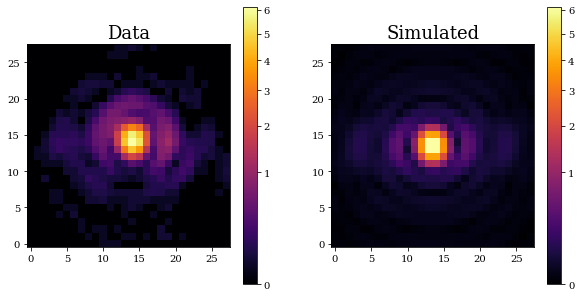

In [78]:
fname = "data/spider/11_laser_180deg_80us_3gain_img_stack_batch_0.npy" #data/spider/08_laser_90deg_img_stack.npy"
data = np.load(fname)
data = data[-1,:,:]

bckgnd = np.load("data/spider/12_laser_180deg_bckgnd_80us_3gain_img_stack_batch_0.npy") 
bckgnd = np.mean(bckgnd)
data = data - bckgnd

# Scale intensity
current_range = data.max() - data.min()
new_range = sim_psf.max() - sim_psf.min()
scaled_data = ( (data - data.min()) * new_range )/current_range + sim_psf.min()

psf_center_idx = np.unravel_index(np.argmax(scaled_data, axis=None), scaled_data.shape)
psf_hlf_sz = 14
scaled_data = scaled_data[psf_center_idx[0]-psf_hlf_sz:psf_center_idx[0]+psf_hlf_sz,
                            psf_center_idx[1]-psf_hlf_sz:psf_center_idx[1]+psf_hlf_sz]

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(scaled_data, norm = norm_psf)
plt.colorbar()
plt.title("Data")
plt.subplot(1,2,2)
plt.imshow(sim_psf, norm = norm_psf)
plt.colorbar()
plt.title("Simulated")

In [79]:
learning_rate = 1e-9
optimisers = [
            optax.adam(learning_rate=learning_rate),
            optax.adam(learning_rate=learning_rate),
            # optax.adam(learning_rate=1e-4),
            optax.adam(learning_rate=1e6),
            # optax.adam(learning_rate=1e-2),
              ]


# Optimise flux first
optim, opt_state = zdx.get_optimiser(instrument, params, optimisers) # Needs to be iterable param (i.e. accessible via instrument class)

progress_bar = tqdm(range(5000), desc='Loss: ')

# Run optimisation loop 
net_losses, Coeffs, Positions, Fluxes, Dist_sum, Pix_resp = [],[],[],[], [], []
for i in progress_bar:
    poiss_loss, poiss_grads = loss_fn_poisson(model = instrument, data = scaled_data)

    updates, opt_state = optim.update(poiss_grads, opt_state)
    instrument = zdx.apply_updates(instrument, updates) 

    net_losses.append(poiss_loss)
    Fluxes.append(instrument.source.flux)
    Coeffs.append(instrument.aperture.coefficients)
    Positions.append(instrument.source.position)
    # Dist_sum.append(instrument.optics.intensity_prof.gauss_param)
    Pix_resp.append(instrument.detector.ApplyBFSPixelResponse.pixel_response)
    
    progress_bar.set_postfix({'Loss': poiss_loss})


Loss:   0%|          | 0/5000 [00:00<?, ?it/s]

Found coefficients for noll idxs: [ 4  5  6  7  8  9 10 11 12 13 14]
[-1.6186041e-08  5.3346647e-09  6.9554495e-10  8.2037510e-10
 -5.1667284e-09  2.9934175e-09 -5.1173132e-09  8.1735649e-09
  7.3023354e-10 -1.7035080e-10 -1.6568660e-09]


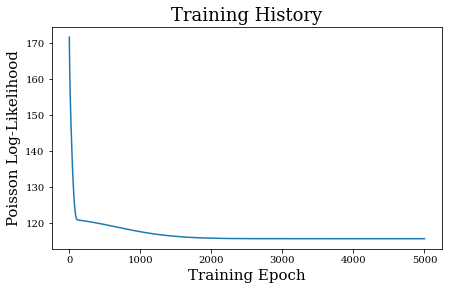

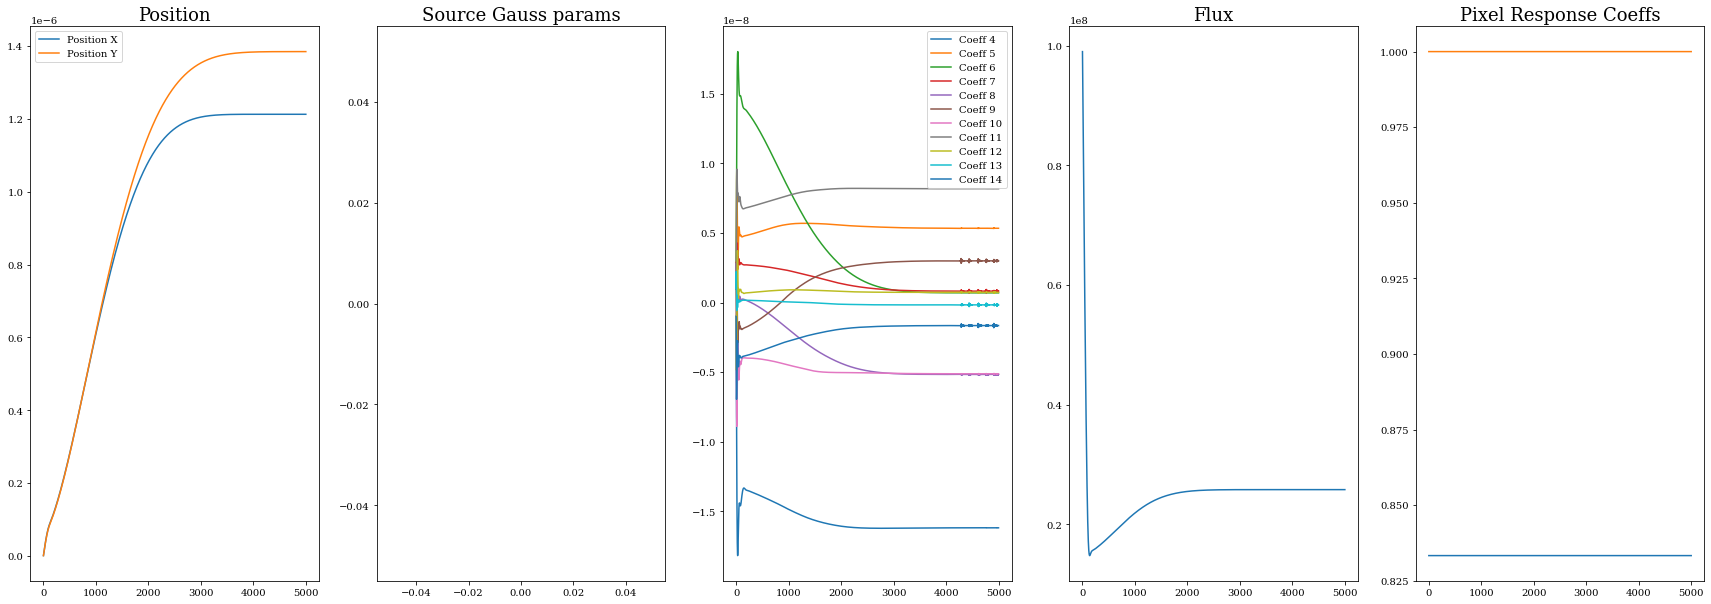

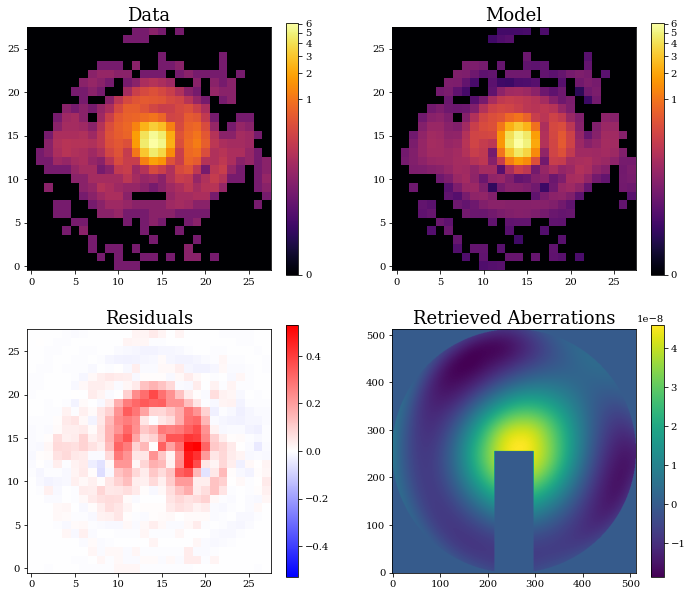

In [80]:
# Visualise results
%matplotlib inline
plt.figure(figsize=(7,4))
plt.plot(np.array(net_losses))
ax = plt.gca()
ax.set_title("Training History")
ax.set_xlabel("Training Epoch")
ax.set_ylabel("Poisson Log-Likelihood")

plt.rcParams['figure.figsize'] = (17, 17)
plt.rcParams['image.cmap'] = 'inferno'

plt.figure(figsize=(30,10))
plt.subplot(1,5,1)
plt.plot(np.asarray(Positions)[:,0,0], label="Position X")
plt.plot(np.asarray(Positions)[:,0,1], label="Position Y")
# plt.plot(np.asarray(Positions)[:,0], label="Position X")
# plt.plot(np.asarray(Positions)[:,1], label="Position Y")
plt.title("Position")
plt.legend()
plt.subplot(1,5,2)
plt.plot(np.asarray(Dist_sum))
plt.title("Source Gauss params")
plt.subplot(1,5,3)
arr_coeffs = np.asarray(Coeffs)
for i in range(len(Coeffs[0])):
    label = "Coeff " + str(zernike_indicies[i])
    plt.plot(arr_coeffs[:,i], label=label)
plt.legend()
plt.subplot(1,5,4)
plt.plot(np.asarray(Fluxes))
plt.title("Flux")
plt.subplot(1,5,5)
plt.plot(np.asarray(Pix_resp))
plt.title("Pixel Response Coeffs")

plt.figure(figsize=(12,10))
norm_psf = PowerNorm(0.2, vmax=scaled_data.max(), vmin=scaled_data.min())
plt.subplot(2,2,1)
plt.imshow(scaled_data, norm=norm_psf)
plt.colorbar()
plt.title('Data')

plt.subplot(2,2,2)
model_psf = instrument.model()
current_range = model_psf.max() - model_psf.min()
new_range = scaled_data.max() - scaled_data.min()
model_psf = ( (model_psf - model_psf.min()) * new_range )/current_range + scaled_data.min()
norm_psf = PowerNorm(0.2, vmax=model_psf.max(), vmin=model_psf.min())
mask = np.ones(scaled_data.shape)
mask[scaled_data < 0.01] = 0
plt.imshow(model_psf*mask, norm=norm_psf)
plt.title('Model')
plt.colorbar()

plt.subplot(2,2,3)
resid = scaled_data - model_psf
# resid = data - model_psf
plt.imshow(resid, cmap='bwr', vmax = np.abs(resid).max(), vmin = -np.abs(resid).max())
plt.colorbar()
plt.title('Residuals')

plt.subplot(2,2,4)
opd = instrument.aperture.eval_basis()
plt.imshow(opd*transmission, cmap='viridis')
plt.title('Retrieved Aberrations')
plt.colorbar()

print("Found coefficients for noll idxs: {}\n{}".format(zernike_indicies, instrument.optics.aperture.coefficients))

run3_coeffs = instrument.optics.aperture.coefficients

In [81]:
# Re-initialise model
optics = dl.AngularOpticalSystem(wf_npixels = wf_npixels, 
                                diameter=wf_diam, 
                                layers=layers, 
                                psf_npixels=psf_npix, 
                                psf_pixel_scale=psf_pixel_scale,
                                oversample=oversample)

instrument = dl.Telescope(optics, ('source', src), detector)
print(instrument.optics.aperture.coefficients, instrument.source.position)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [[0. 0.]]


Text(0.5, 1.0, 'Simulated')

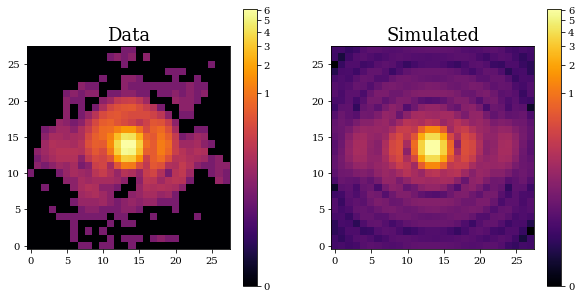

In [82]:
fname = "data/spider/12_laser_180deg_80us_3gain_img_stack_batch_0.npy" #data/spider/08_laser_90deg_img_stack.npy"
data = np.load(fname)
data = data[-1,:,:]

bckgnd = np.load("data/spider/12_laser_180deg_bckgnd_80us_3gain_img_stack_batch_0.npy") 
bckgnd = np.mean(bckgnd)
data = data - bckgnd

# Scale intensity
current_range = data.max() - data.min()
new_range = sim_psf.max() - sim_psf.min()
scaled_data = ( (data - data.min()) * new_range )/current_range + sim_psf.min()

psf_center_idx = np.unravel_index(np.argmax(scaled_data, axis=None), scaled_data.shape)
psf_hlf_sz = 14
scaled_data = scaled_data[psf_center_idx[0]-psf_hlf_sz:psf_center_idx[0]+psf_hlf_sz,
                            psf_center_idx[1]-psf_hlf_sz:psf_center_idx[1]+psf_hlf_sz]

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(scaled_data, norm = norm_psf)
plt.colorbar()
plt.title("Data")
plt.subplot(1,2,2)
plt.imshow(sim_psf, norm = norm_psf)
plt.colorbar()
plt.title("Simulated")

In [83]:
learning_rate = 1e-9
optimisers = [
            optax.adam(learning_rate=learning_rate),
            optax.adam(learning_rate=learning_rate),
            # optax.adam(learning_rate=1e-4),
            optax.adam(learning_rate=1e6),
            # optax.adam(learning_rate=1e-2),
              ]


# Optimise flux first
optim, opt_state = zdx.get_optimiser(instrument, params, optimisers) # Needs to be iterable param (i.e. accessible via instrument class)

progress_bar = tqdm(range(5000), desc='Loss: ')

# Run optimisation loop 
net_losses, Coeffs, Positions, Fluxes, Dist_sum, Pix_resp = [],[],[],[], [], []
for i in progress_bar:
    poiss_loss, poiss_grads = loss_fn_poisson(model = instrument, data = scaled_data)

    updates, opt_state = optim.update(poiss_grads, opt_state)
    instrument = zdx.apply_updates(instrument, updates) 

    net_losses.append(poiss_loss)
    Fluxes.append(instrument.source.flux)
    Coeffs.append(instrument.aperture.coefficients)
    Positions.append(instrument.source.position)
    # Dist_sum.append(instrument.optics.intensity_prof.gauss_param)
    Pix_resp.append(instrument.detector.ApplyBFSPixelResponse.pixel_response)
    
    progress_bar.set_postfix({'Loss': poiss_loss})


Loss:   0%|          | 0/5000 [00:00<?, ?it/s]

Found coefficients for noll idxs: [ 4  5  6  7  8  9 10 11 12 13 14]
[-1.5373240e-08  5.0287632e-09 -4.3635159e-10 -4.0850115e-11
 -5.2665623e-09  4.0714667e-09 -6.1635865e-09  8.1995610e-09
  1.1070912e-09  5.7937533e-10 -1.6295303e-09]


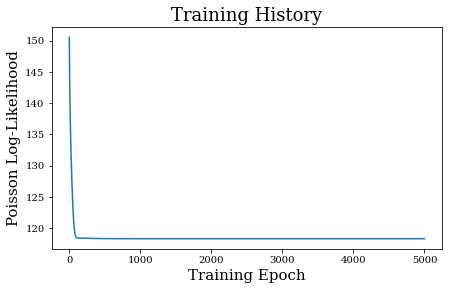

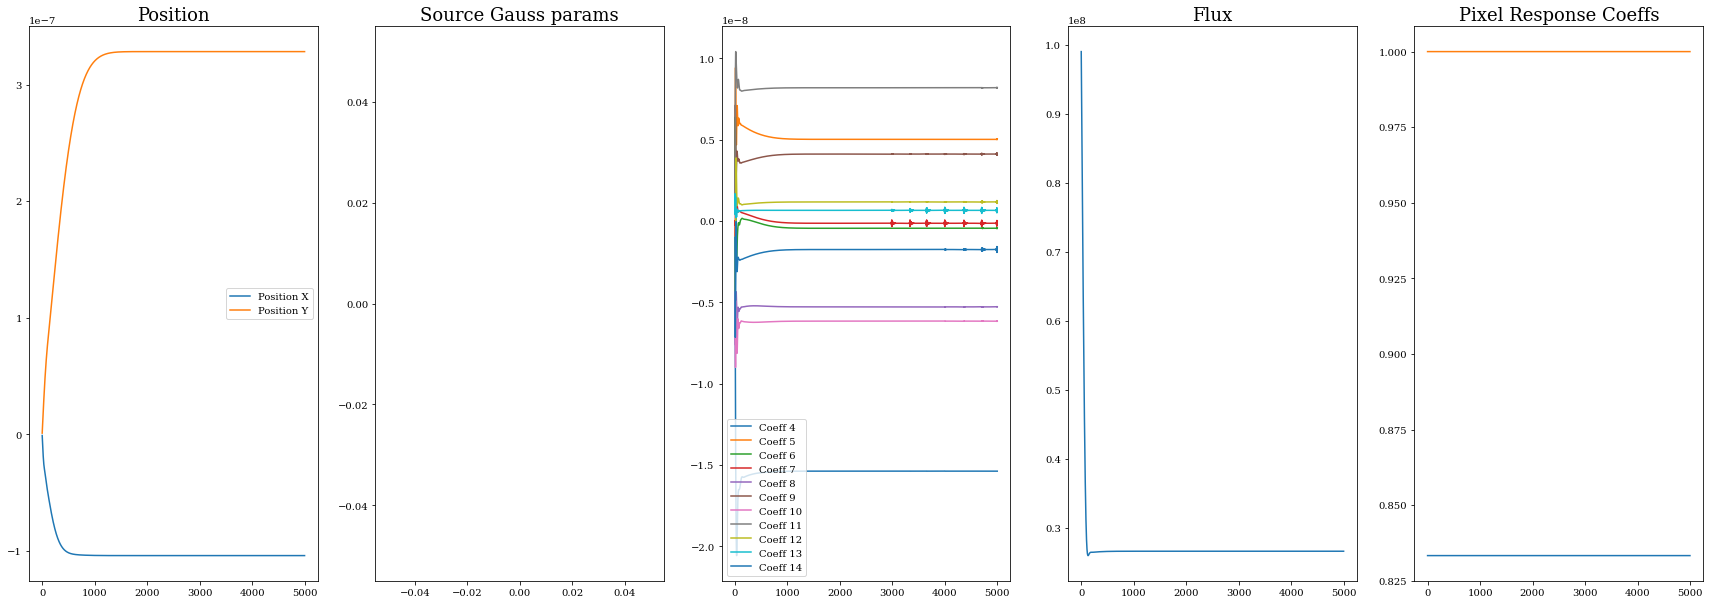

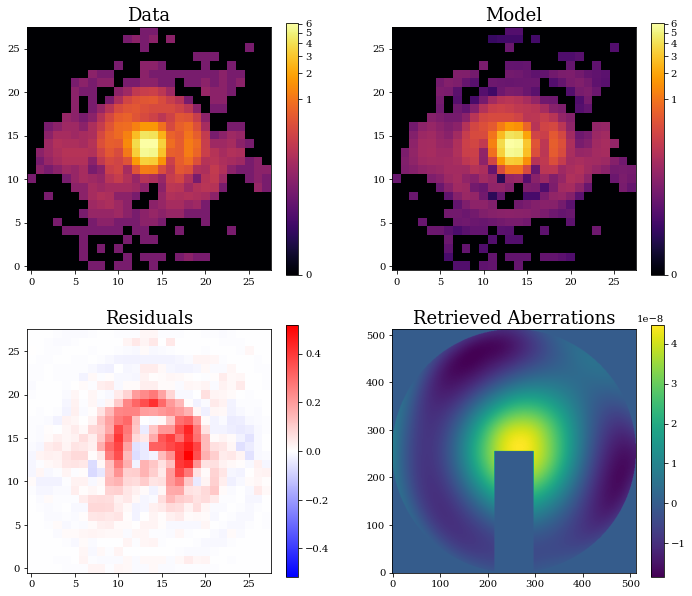

In [84]:
# Visualise results
%matplotlib inline
plt.figure(figsize=(7,4))
plt.plot(np.array(net_losses))
ax = plt.gca()
ax.set_title("Training History")
ax.set_xlabel("Training Epoch")
ax.set_ylabel("Poisson Log-Likelihood")

plt.rcParams['figure.figsize'] = (17, 17)
plt.rcParams['image.cmap'] = 'inferno'

plt.figure(figsize=(30,10))
plt.subplot(1,5,1)
plt.plot(np.asarray(Positions)[:,0,0], label="Position X")
plt.plot(np.asarray(Positions)[:,0,1], label="Position Y")
# plt.plot(np.asarray(Positions)[:,0], label="Position X")
# plt.plot(np.asarray(Positions)[:,1], label="Position Y")
plt.title("Position")
plt.legend()
plt.subplot(1,5,2)
plt.plot(np.asarray(Dist_sum))
plt.title("Source Gauss params")
plt.subplot(1,5,3)
arr_coeffs = np.asarray(Coeffs)
for i in range(len(Coeffs[0])):
    label = "Coeff " + str(zernike_indicies[i])
    plt.plot(arr_coeffs[:,i], label=label)
plt.legend()
plt.subplot(1,5,4)
plt.plot(np.asarray(Fluxes))
plt.title("Flux")
plt.subplot(1,5,5)
plt.plot(np.asarray(Pix_resp))
plt.title("Pixel Response Coeffs")

plt.figure(figsize=(12,10))
norm_psf = PowerNorm(0.2, vmax=scaled_data.max(), vmin=scaled_data.min())
plt.subplot(2,2,1)
plt.imshow(scaled_data, norm=norm_psf)
plt.colorbar()
plt.title('Data')

plt.subplot(2,2,2)
model_psf = instrument.model()
current_range = model_psf.max() - model_psf.min()
new_range = scaled_data.max() - scaled_data.min()
model_psf = ( (model_psf - model_psf.min()) * new_range )/current_range + scaled_data.min()
norm_psf = PowerNorm(0.2, vmax=model_psf.max(), vmin=model_psf.min())
mask = np.ones(scaled_data.shape)
mask[scaled_data < 0.01] = 0
plt.imshow(model_psf*mask, norm=norm_psf)
plt.title('Model')
plt.colorbar()

plt.subplot(2,2,3)
resid = scaled_data - model_psf
# resid = data - model_psf
plt.imshow(resid, cmap='bwr', vmax = np.abs(resid).max(), vmin = -np.abs(resid).max())
plt.colorbar()
plt.title('Residuals')

plt.subplot(2,2,4)
opd = instrument.aperture.eval_basis()
plt.imshow(opd*transmission, cmap='viridis')
plt.title('Retrieved Aberrations')
plt.colorbar()

print("Found coefficients for noll idxs: {}\n{}".format(zernike_indicies, instrument.optics.aperture.coefficients))

run4_coeffs = instrument.optics.aperture.coefficients

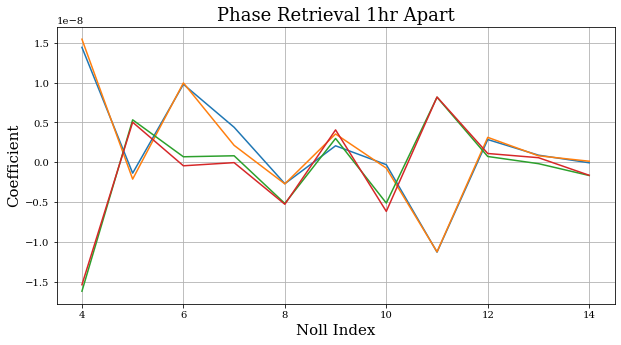

In [85]:
plt.figure(figsize=(10,5))
x = np.arange(2,11)
plt.plot(zernike_indicies,run1_coeffs, label='Run 1')
plt.plot(zernike_indicies, run2_coeffs, label='Run 2')
plt.plot(zernike_indicies,run3_coeffs, label='Run 3')
plt.plot(zernike_indicies, run4_coeffs, label='Run 4')
plt.xlabel('Noll Index')
plt.ylabel('Coefficient')
plt.title("Phase Retrieval 1hr Apart")
plt.grid()

#### Let's try ✨Phase Diversity (sort of)✨ Using two different Spider Orientations ☀️
- Phase Diversity involves taking a second image with a known aberration applied. We have just taken a second image
with a different known spider orientation, but we can optimise using both scenarios simultaneously. 

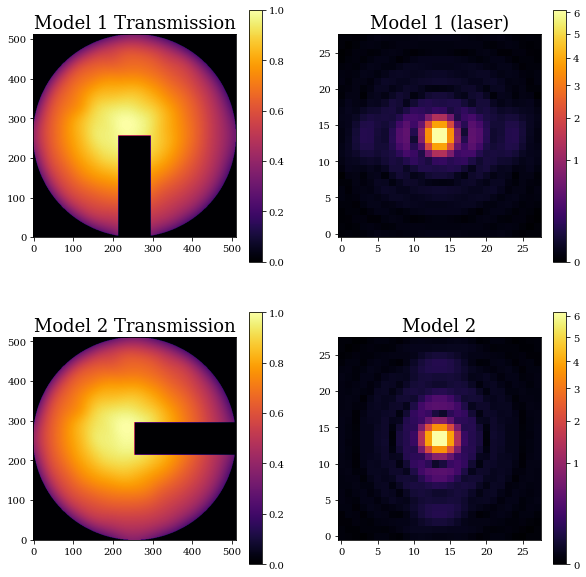

In [86]:
# --- Simulate Spider -----------------------------------------------------------------#
circle = dlu.circle(coords=coords, radius=aperture_diameter/2) 
spider = dlu.spider(coords=coords, width=spider_width, angles=[0]) 
transmission = dlu.combine([circle, spider]) 
transmission *= intensity_dist

# Zernike aberrations
coeffs = np.zeros(zernike_indicies.shape)
basis = dlu.zernike_basis(js=zernike_indicies, coordinates=coords, diameter=aperture_diameter)

layers = [
    ('aperture', dl.layers.BasisOptic(basis, transmission, coeffs, normalise=False))
]

# Construct Optics
optics_1 = dl.AngularOpticalSystem(wf_npixels = wf_npixels, 
                                diameter=wf_diam, 
                                layers=layers, 
                                psf_npixels=psf_npix, 
                                psf_pixel_scale=psf_pixel_scale,
                                oversample=oversample)
model_sp0 = dl.Telescope(optics_1, ('source', src), detector)


sim_psf = model_sp0.model()
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(transmission)
plt.colorbar()
plt.title('Model 1 Transmission')
plt.subplot(2,2,2)
norm_psf = PowerNorm(0.5, vmax=sim_psf.max(), vmin=sim_psf.min())
plt.imshow(sim_psf, norm=norm_psf)
plt.title('Model 1 (laser)')
plt.colorbar()

spider = dlu.spider(coords=coords, width=spider_width, angles=[spider_angle]) 
transmission = dlu.combine([circle, spider]) 
transmission *= intensity_dist
layers = [
    ('aperture', dl.layers.BasisOptic(basis, transmission, coeffs, normalise=False))
]

optics_2 = dl.AngularOpticalSystem(wf_npixels = wf_npixels, 
                                diameter=wf_diam, 
                                layers=layers, 
                                psf_npixels=psf_npix, 
                                psf_pixel_scale=psf_pixel_scale,
                                oversample=oversample)
model_sp270 = dl.Telescope(optics_2, ('source', src), detector)

sim_psf = model_sp270.model()

plt.subplot(2,2,3)
plt.imshow(transmission)
plt.colorbar()
plt.title('Model 2 Transmission')
plt.subplot(2,2,4)
norm_psf = PowerNorm(0.5, vmax=sim_psf.max(), vmin=sim_psf.min())
plt.imshow(sim_psf, norm=norm_psf)
plt.title('Model 2')
plt.colorbar()


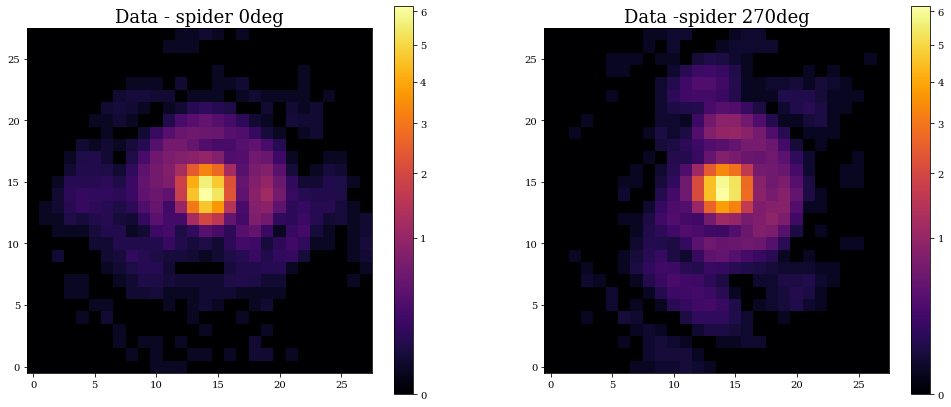

In [87]:
DATA_PSFS = []
fnames = ["data/spider/11_laser_180deg_80us_3gain_img_stack_batch_0.npy", "data/spider/10_laser_90deg_200us_0gain_img_stack_batch_0.npy"]
            # model with spider at 0deg                            model with spider at 270deg
for i in range(len(fnames)):
    fname = fnames[i]
    data = np.load(fname)
    data = data[-1,:,:]

    # Scale intensity
    current_range = data.max() - data.min()
    new_range = sim_psf.max() - sim_psf.min()
    scaled_data = ( (data - data.min()) * new_range )/current_range + sim_psf.min()

    psf_center_idx = np.unravel_index(np.argmax(scaled_data, axis=None), scaled_data.shape)
    psf_hlf_sz = 14
    scaled_data = scaled_data[psf_center_idx[0]-psf_hlf_sz:psf_center_idx[0]+psf_hlf_sz,
                                psf_center_idx[1]-psf_hlf_sz:psf_center_idx[1]+psf_hlf_sz]
    
    DATA_PSFS.append(scaled_data)  

plt.figure(figsize=(17,7))
plt.subplot(1,2,1)
plt.imshow(DATA_PSFS[0], norm = norm_psf)
plt.title("Data - spider 0deg")
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(DATA_PSFS[1], norm = norm_psf)
plt.title("Data -spider 270deg")
plt.colorbar()


In [88]:
learning_rate = 1e-9

optim, opt_state = zdx.get_optimiser(model_sp270, params, optimisers) # all same params as previous fitting
progress_bar = tqdm(range(6000), desc='Loss: ')

# Run optimisation loop 
net_losses, Coeffs, Positions, Fluxes = [], [], [], []
models = [model_sp0, model_sp270] # model configurations
for i in progress_bar:
  grads = None
  net_loss = 0
  mean_coeff_grads, mean_position_grads, mean_flux_grads = None, None, None # to set initially in loop
  for j in range(len(models)):
    loss, grads = loss_fn_poisson(model = models[j], data = DATA_PSFS[j])
    net_loss += loss 

    if j == 0:
      mean_coeff_grads = grads.aperture.coefficients/len(models)
      mean_position_grads = grads.source.position/len(models)
      mean_flux_grads = grads.source.flux/len(models)
    else:
      mean_coeff_grads += grads.aperture.coefficients/len(models)
      mean_position_grads += grads.source.position/len(models)
      mean_flux_grads += grads.source.flux/len(models)

  grads = grads.set('aperture.coefficients', mean_coeff_grads)
  grads = grads.set('source.position', mean_position_grads)
  grads = grads.set('source.flux', mean_flux_grads)

  updates, opt_state = optim.update(grads, opt_state)
  for j in range(len(models)):
    models[j] = zdx.apply_updates(models[j], updates)

  net_losses.append(net_loss)
  Fluxes.append(models[0].source.flux)
  Coeffs.append(models[0].aperture.coefficients)
  Positions.append(models[0].source.position)

  progress_bar.set_postfix({'Loss': loss})


Loss:   0%|          | 0/6000 [00:00<?, ?it/s]

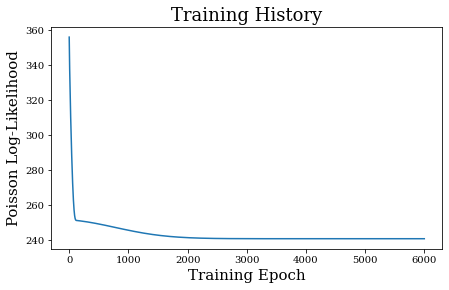

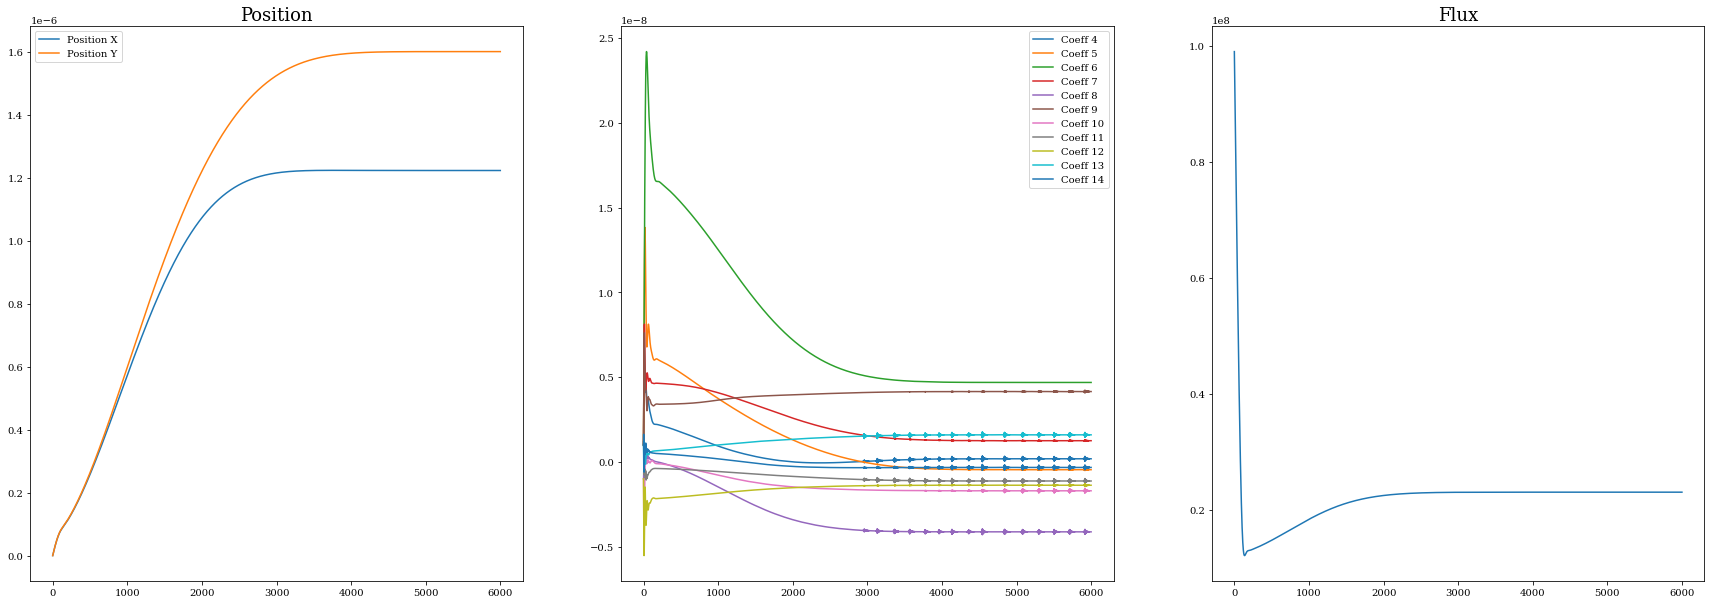

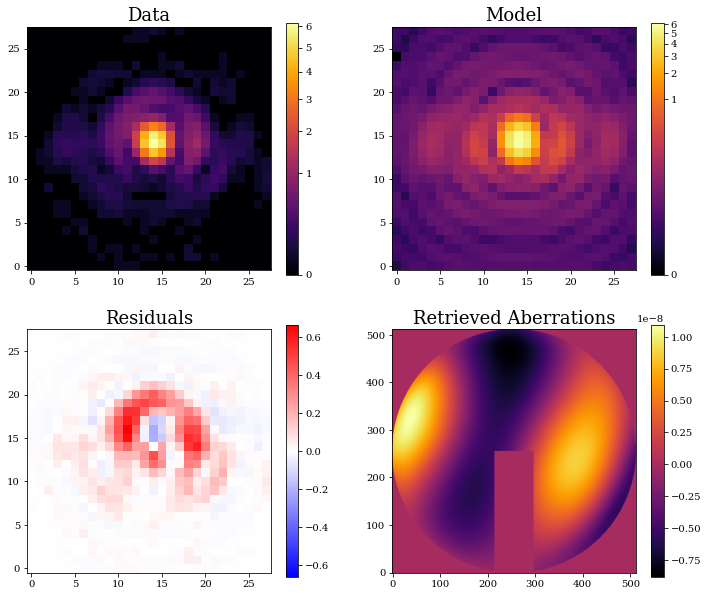

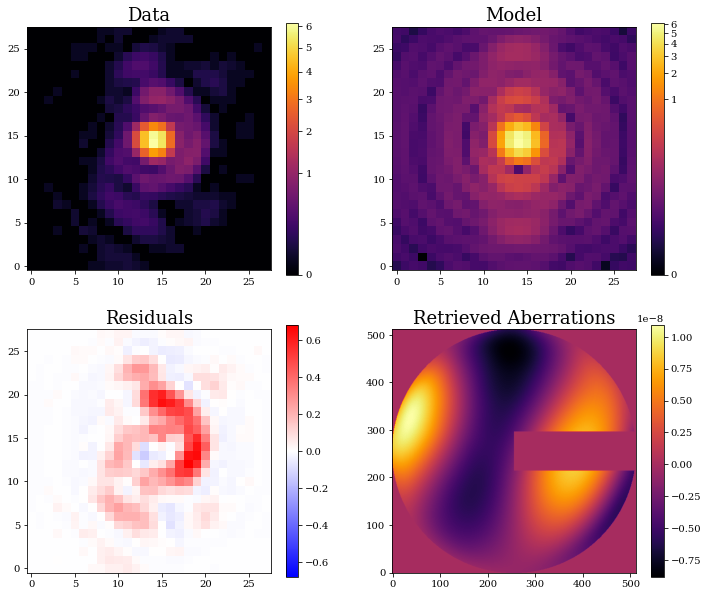

In [89]:
# Visualise results
plt.figure(figsize=(7,4))
plt.plot(np.array(net_losses))
ax = plt.gca()
ax.set_title("Training History")
ax.set_xlabel("Training Epoch")
ax.set_ylabel("Poisson Log-Likelihood")

plt.rcParams['figure.figsize'] = (17, 17)
plt.rcParams['image.cmap'] = 'inferno'

plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plt.plot(np.asarray(Positions)[:,0,0], label="Position X")
plt.plot(np.asarray(Positions)[:,0,1], label="Position Y")
# plt.plot(np.asarray(Positions)[:,0], label="Position X")
# plt.plot(np.asarray(Positions)[:,1], label="Position Y")
plt.title("Position")
plt.legend()
plt.subplot(1,3,2)
arr_coeffs = np.asarray(Coeffs)
for i in range(len(Coeffs[0])):
    label = "Coeff " + str(zernike_indicies[i])
    plt.plot(arr_coeffs[:,i], label=label)
plt.legend()
plt.subplot(1,3,3)
plt.plot(np.asarray(Fluxes))
plt.title("Flux")

for i, data in enumerate(DATA_PSFS):
    plt.figure(figsize=(12,10))
    norm_psf = PowerNorm(0.5, vmax=data.max(), vmin=data.min())
    plt.subplot(2,2,1)
    plt.imshow(data, norm=norm_psf)
    plt.colorbar()
    plt.title('Data')

    plt.subplot(2,2,2)
    model_psf = models[i].model()
    current_range = model_psf.max() - model_psf.min()
    new_range = data.max() - data.min()
    model_psf = ( (model_psf - model_psf.min()) * new_range )/current_range + scaled_data.min()
    norm_psf = PowerNorm(0.2, vmax=model_psf.max(), vmin=model_psf.min())
    plt.imshow(model_psf, norm=norm_psf)
    plt.title('Model')
    plt.colorbar()

    plt.subplot(2,2,3)
    resid = data - model_psf
    plt.imshow(resid, cmap='bwr', vmax = np.abs(resid).max(), vmin = -np.abs(resid).max())
    plt.colorbar()
    plt.title('Residuals')

    plt.subplot(2,2,4)
    opd = models[i].aperture.eval_basis()
    plt.imshow(opd*models[i].aperture.transmission)
    plt.title('Retrieved Aberrations')
    plt.colorbar()